In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

In [3]:
df.head(5)

,Age,Gender,Income,Location,Ad Type,Ad Topic,Ad Placement,Clicks,Click Time,Conversion Rate,CTR
0,61,Male,35717.43,Urban,Banner,Travel,Social Media,3,2024-01-18 20:45:56.898459,0.0981,0.0737
1,41,Male,47453.25,Rural,Video,Travel,Search Engine,5,2023-04-24 20:45:56.898459,0.0937,0.0592
2,49,Female,68126.35,Rural,Text,Food,Social Media,4,2024-02-24 20:45:56.898459,0.1912,0.0563
3,68,Female,64585.73,Suburban,Text,Health,Website,6,2023-12-13 20:45:56.898459,0.1122,0.0232
4,63,Male,21109.40,Urban,Native,Fashion,Search Engine,5,2023-07-02 20:45:56.898459,0.1426,0.0539


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              10000 non-null  int64  
 1   Gender           10000 non-null  object 
 2   Income           10000 non-null  float64
 3   Location         10000 non-null  object 
 4   Ad Type          10000 non-null  object 
 5   Ad Topic         10000 non-null  object 
 6   Ad Placement     10000 non-null  object 
 7   Clicks           10000 non-null  int64  
 8   Click Time       10000 non-null  object 
 9   Conversion Rate  10000 non-null  float64
 10  CTR              10000 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 859.5+ KB


In [5]:
df.describe()
print(df.isna().sum())
# Wow! No missing data. How the helly did they make this? Whatever I guess.


Age                0
Gender             0
Income             0
Location           0
Ad Type            0
Ad Topic           0
Ad Placement       0
Clicks             0
Click Time         0
Conversion Rate    0
CTR                0
dtype: int64


In [6]:
# Great piece of code here wow.
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")
    if unique_vals < 15:  # show actual values if few
        print(df[col].unique(), "\n")


Age: 100 unique values
Gender: 3 unique values
['Male' 'Female' 'Other'] 

Income: 9994 unique values
Location: 3 unique values
['Urban' 'Rural' 'Suburban'] 

Ad Type: 4 unique values
['Banner' 'Video' 'Text' 'Native'] 

Ad Topic: 6 unique values
['Travel' 'Food' 'Health' 'Fashion' 'Technology' 'Finance'] 

Ad Placement: 3 unique values
['Social Media' 'Search Engine' 'Website'] 

Clicks: 17 unique values
Click Time: 6503 unique values
Conversion Rate: 3955 unique values
CTR: 1008 unique values


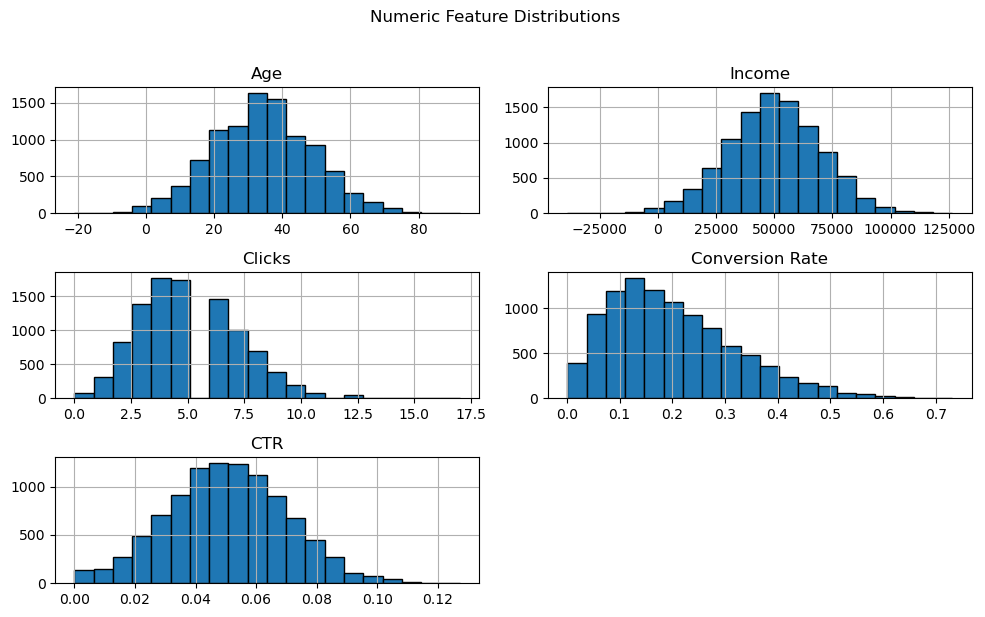

In [7]:
# okay this is good cause I need to see the distribution.
numeric_cols = ['Age', 'Income', 'Clicks', 'Conversion Rate', 'CTR']

df[numeric_cols].hist(bins=20, figsize=(10,6), edgecolor='black')
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


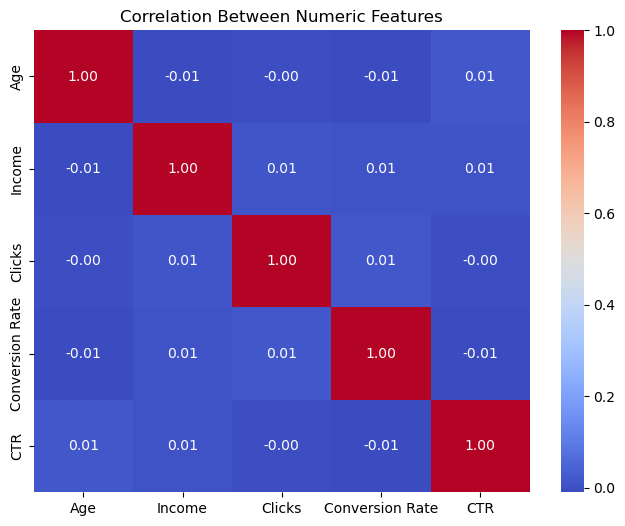

In [8]:
# This one is hard to understand tbh
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

C:\Users\ianta\AppData\Local\Temp\ipykernel_32552\3244514290.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Gender', y='Income', palette='pastel')


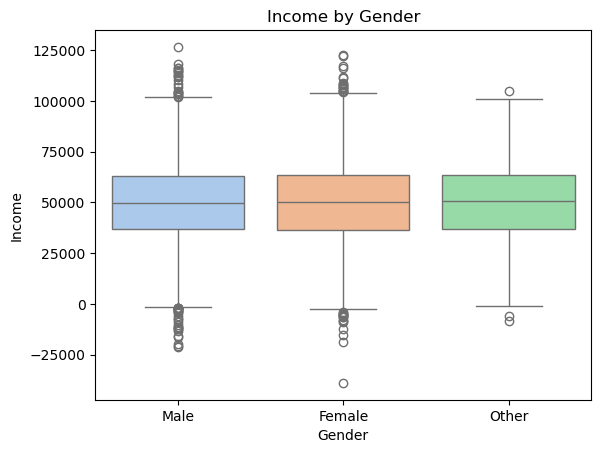

C:\Users\ianta\AppData\Local\Temp\ipykernel_32552\3244514290.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Ad Type', y='CTR', palette='pastel')


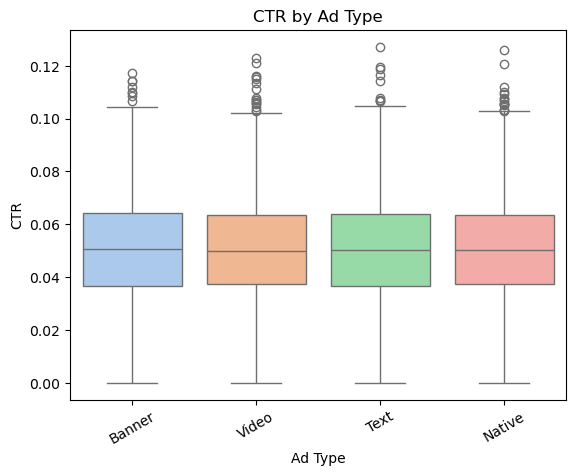

C:\Users\ianta\AppData\Local\Temp\ipykernel_32552\3244514290.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Ad Type', y='Conversion Rate', palette='pastel')


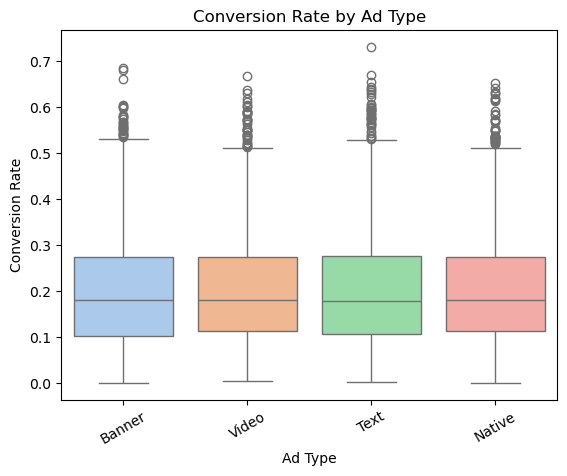

In [9]:
# THis has some interesting stuff... Hmm
sns.boxplot(data=df, x='Gender', y='Income', palette='pastel')
plt.title("Income by Gender")
plt.show()

sns.boxplot(data=df, x='Ad Type', y='CTR', palette='pastel')
plt.title("CTR by Ad Type")
plt.xticks(rotation=30)
plt.show()

sns.boxplot(data=df, x='Ad Type', y='Conversion Rate', palette='pastel')
plt.title("Conversion Rate by Ad Type")
plt.xticks(rotation=30)
plt.show()


C:\Users\ianta\AppData\Local\Temp\ipykernel_32552\3857479832.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Click Month', palette='pastel', order=df['Click Month'].value_counts().index)


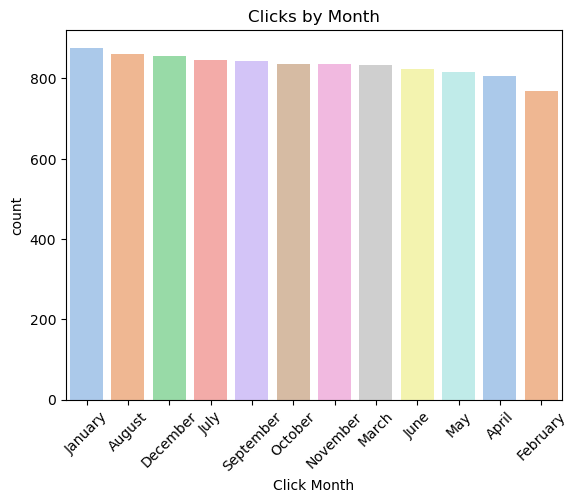

C:\Users\ianta\AppData\Local\Temp\ipykernel_32552\3857479832.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Click Day', palette='pastel', order=day_order)


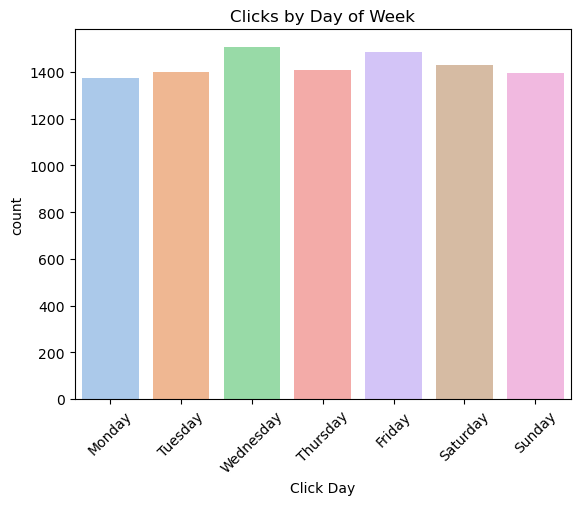

In [10]:
# I like this because now I have more time series data, and I can see when there is more clicks per month.
df['Click Time'] = pd.to_datetime(df['Click Time'])
df['Click Hour'] = df['Click Time'].dt.hour
df['Click Month'] = df['Click Time'].dt.month_name()
df['Click Day'] = df['Click Time'].dt.day_name()


sns.countplot(data=df, x='Click Month', palette='pastel', order=df['Click Month'].value_counts().index)
plt.title("Clicks by Month")
plt.xticks(rotation=45)
plt.show()

# # the time stamps are sort've useless because they're all only different by miliseconds...
# sns.countplot(data=df, x='Click Hour', palette='pastel', order=df['Click Hour'].value_counts().index)
# plt.title("Clicks by Month")
# plt.xticks(rotation=45)
# plt.show()

# the day it was clicked might be better actually...
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(data=df, x='Click Day', palette='pastel', order=day_order)
plt.title("Clicks by Day of Week")
plt.xticks(rotation=45)
plt.show()

In [11]:
df.info()
# notice we have a datatime64 Dtype now, and then there are two new columns since we extracted data from click time.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Age              10000 non-null  int64         
 1   Gender           10000 non-null  object        
 2   Income           10000 non-null  float64       
 3   Location         10000 non-null  object        
 4   Ad Type          10000 non-null  object        
 5   Ad Topic         10000 non-null  object        
 6   Ad Placement     10000 non-null  object        
 7   Clicks           10000 non-null  int64         
 8   Click Time       10000 non-null  datetime64[ns]
 9   Conversion Rate  10000 non-null  float64       
 10  CTR              10000 non-null  float64       
 11  Click Hour       10000 non-null  int32         
 12  Click Month      10000 non-null  object        
 13  Click Day        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32

In [12]:
# Creates new coluns wcih idk fi 
print(df.groupby('Gender')[['Clicks', 'CTR', 'Conversion Rate']].mean())
print(df.groupby('Ad Type')[['Clicks', 'CTR', 'Conversion Rate']].mean())

          Clicks       CTR  Conversion Rate
Gender                                     
Female  5.030540  0.050767         0.201616
Male    5.035700  0.050153         0.203369
Other   5.006654  0.050425         0.199294
           Clicks       CTR  Conversion Rate
Ad Type                                     
Banner   5.014062  0.050403         0.200075
Native   5.079513  0.050441         0.204576
Text     5.049513  0.050205         0.201899
Video    4.980884  0.050647         0.202512


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Age              10000 non-null  int64         
 1   Gender           10000 non-null  object        
 2   Income           10000 non-null  float64       
 3   Location         10000 non-null  object        
 4   Ad Type          10000 non-null  object        
 5   Ad Topic         10000 non-null  object        
 6   Ad Placement     10000 non-null  object        
 7   Clicks           10000 non-null  int64         
 8   Click Time       10000 non-null  datetime64[ns]
 9   Conversion Rate  10000 non-null  float64       
 10  CTR              10000 non-null  float64       
 11  Click Hour       10000 non-null  int32         
 12  Click Month      10000 non-null  object        
 13  Click Day        10000 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32

### Claude popped off and did a bunch of code here

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load your data
df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

# Data inspection and cleaning
print("="*80)
print("DATA INSPECTION")
print("="*80)
print("\nDataset shape:", df.shape)
print("\nColumn data types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

# Convert Click Time to datetime if needed
df['Click Time'] = pd.to_datetime(df['Click Time'])

# Ensure numeric columns are properly typed
numeric_cols = ['Age', 'Income', 'Clicks', 'Conversion Rate', 'CTR']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop any rows with missing values in key columns
df_clean = df.dropna(subset=numeric_cols)
print(f"\nRows after cleaning: {len(df_clean)} (dropped {len(df) - len(df_clean)} rows)")

# Create dummy variables for categorical variables
df_encoded = pd.get_dummies(df_clean, columns=['Gender', 'Location', 'Ad Type', 'Ad Topic', 'Ad Placement'], 
                             drop_first=True)

# Verify no object types remain in encoded data
print("\nEncoded data types:")
print(df_encoded.dtypes.value_counts())

print("="*80)
print("ECONOMETRIC DIAGNOSTICS ANALYSIS")
print("="*80)

# ============================================================================
# 1. ENDOGENEITY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("1. ENDOGENEITY ANALYSIS")
print("="*80)

print("\nPotential Endogeneity Issues:")
print("-" * 40)

# Check correlation between Clicks and dependent variables
print("\n1.1 Correlation Analysis (Potential Endogeneity Red Flags):")
print("-" * 40)
corr_matrix = df_clean[['Clicks', 'CTR', 'Conversion Rate', 'Age', 'Income']].corr()
print("\nCorrelation with Clicks (potential endogenous variable):")
print(corr_matrix['Clicks'].sort_values(ascending=False))


# Test for endogeneity using Hausman-Wu test approach
print("\n1.2 Testing for Endogeneity (Hausman-Wu Test Approach):")
print("-" * 40)

# Prepare variables for Conversion Rate model
y = df_encoded['Conversion Rate'].values
X_vars = ['Age', 'Income', 'Clicks']
X_cats = [col for col in df_encoded.columns if col.startswith(('Gender_', 'Location_', 
          'Ad Type_', 'Ad Topic_', 'Ad Placement_'))]

# Ensure all columns exist and are numeric
available_X_vars = [v for v in X_vars if v in df_encoded.columns]
available_X_cats = [c for c in X_cats if c in df_encoded.columns]

print(f"Using {len(available_X_vars)} numeric variables: {available_X_vars}")
print(f"Using {len(available_X_cats)} categorical dummy variables")

X = df_encoded[available_X_vars + available_X_cats].astype(float)
X = add_constant(X)

# Stage 1: Regress potentially endogenous variable (Clicks) on instruments + exogenous
# Using Age and Income as instruments (assuming they're exogenous)
instruments = ['Age', 'Income'] + available_X_cats
available_instruments = [i for i in instruments if i in df_encoded.columns]
X_stage1 = df_encoded[available_instruments].astype(float)
X_stage1 = add_constant(X_stage1)

try:
    model_stage1 = OLS(df_encoded['Clicks'].astype(float).values, X_stage1).fit()
    residuals_stage1 = model_stage1.resid

    # Stage 2: Include residuals in original regression
    X_with_resid = X.copy()
    X_with_resid['clicks_residual'] = residuals_stage1
    model_stage2 = OLS(y, X_with_resid).fit()

    # Test if residual coefficient is significant
    resid_pvalue = model_stage2.pvalues['clicks_residual']
    print(f"\nResidual coefficient p-value: {resid_pvalue:.4f}")
    if resid_pvalue < 0.05:
        print("✗ ENDOGENEITY DETECTED: Clicks appears to be endogenous (p < 0.05)")
        print("  Recommendation: Use Instrumental Variables (IV) regression or 2SLS")
    else:
        print("✓ No strong evidence of endogeneity in Clicks (p ≥ 0.05)")
except Exception as e:
    print(f"⚠️  Could not complete endogeneity test: {str(e)}")
    print("   This may be due to perfect multicollinearity or data issues")

# Calculate VIF for multicollinearity (related to endogeneity)
print("\n1.3 Variance Inflation Factors (VIF) - Multicollinearity Check:")
print("-" * 40)
try:
    X_vif = df_encoded[['Age', 'Income', 'Clicks']].astype(float)
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    print(vif_data)
    print("\nVIF > 10 suggests high multicollinearity (potential endogeneity concern)")
except Exception as e:
    print(f"⚠️  Could not calculate VIF: {str(e)}")


DATA INSPECTION

Dataset shape: (10000, 11)

Column data types:
Age                  int64
Gender              object
Income             float64
Location            object
Ad Type             object
Ad Topic            object
Ad Placement        object
Clicks               int64
Click Time          object
Conversion Rate    float64
CTR                float64
dtype: object

First few rows:
   Age  Gender    Income  Location Ad Type Ad Topic   Ad Placement  Clicks  \
0   61    Male  35717.43     Urban  Banner   Travel   Social Media       3   
1   41    Male  47453.25     Rural   Video   Travel  Search Engine       5   
2   49  Female  68126.35     Rural    Text     Food   Social Media       4   
3   68  Female  64585.73  Suburban    Text   Health        Website       6   
4   63    Male  21109.40     Urban  Native  Fashion  Search Engine       5   

                   Click Time  Conversion Rate     CTR  
0  2024-01-18 20:45:56.898459           0.0981  0.0737  
1  2023-04-24 20:45:56.89

I want to do one more endogenity test I think...


2. HETEROSKEDASTICITY ANALYSIS

2.1 Breusch-Pagan Test:
----------------------------------------
LM Statistic: 23.4603
LM-Test p-value: 0.1349
F-Statistic: 1.3808
F-Test p-value: 0.1348
✓ No strong evidence of heteroskedasticity (p ≥ 0.05)

2.2 White Test:
----------------------------------------
LM Statistic: 138.6292
LM-Test p-value: 0.5169
F-Statistic: 0.9900
F-Test p-value: 0.5178
✓ No strong evidence of heteroskedasticity (p ≥ 0.05)

2.3 Visual Inspection:
----------------------------------------
Generating residual plots...


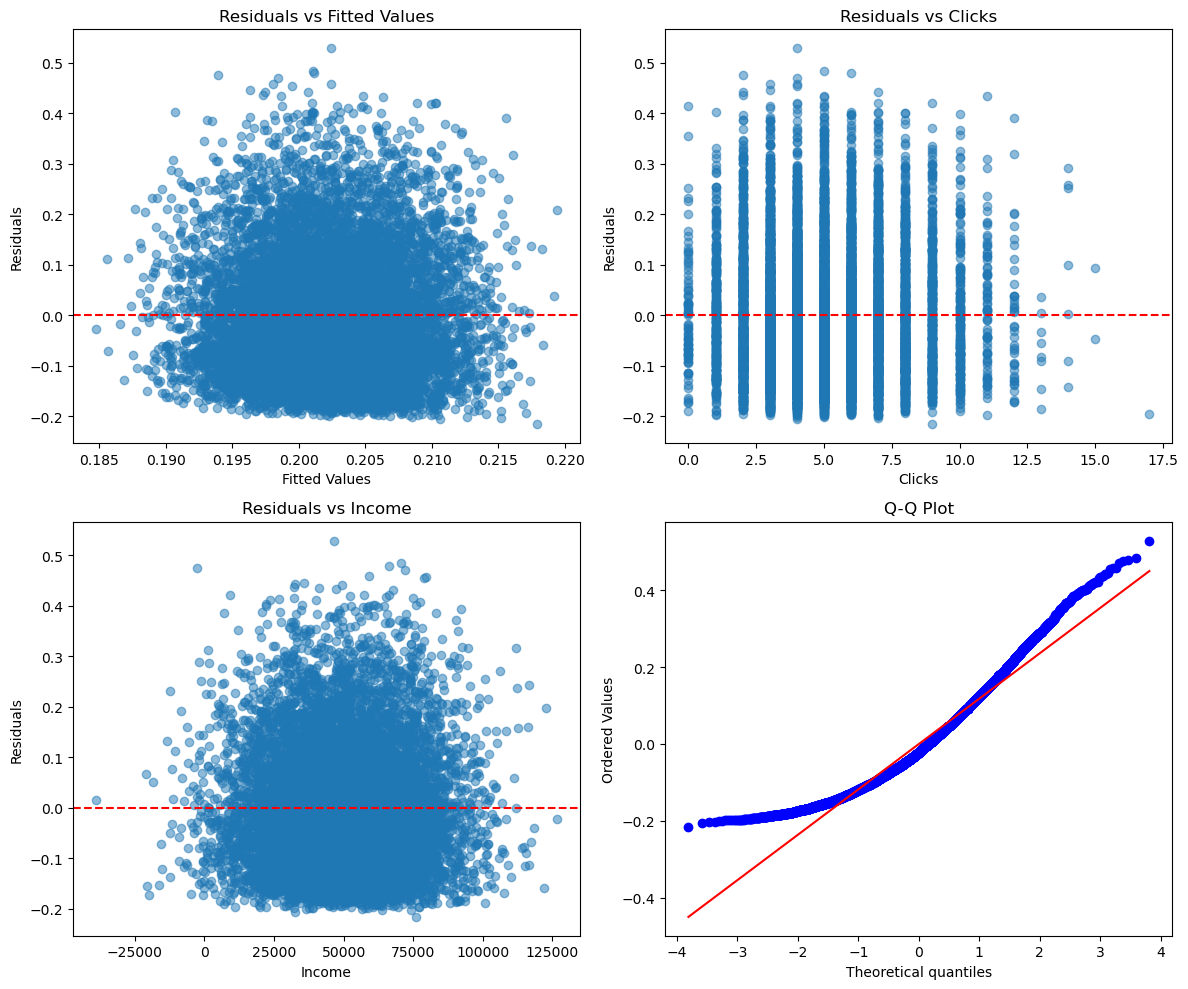

In [15]:

# ============================================================================
# 2. HETEROSKEDASTICITY TESTS
# ============================================================================
print("\n" + "="*80)
print("2. HETEROSKEDASTICITY ANALYSIS")
print("="*80)

# Run base model for heteroskedasticity tests
try:
    base_model = OLS(y, X).fit()
    
    # Breusch-Pagan Test
    print("\n2.1 Breusch-Pagan Test:")
    print("-" * 40)
    bp_test = het_breuschpagan(base_model.resid, X)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    bp_results = dict(zip(labels, bp_test))
    for key, val in bp_results.items():
        print(f"{key}: {val:.4f}")

    if bp_results['LM-Test p-value'] < 0.05:
        print("✗ HETEROSKEDASTICITY DETECTED (p < 0.05)")
        print("  Recommendation: Use robust standard errors (HC1, HC3) or WLS")
    else:
        print("✓ No strong evidence of heteroskedasticity (p ≥ 0.05)")

    # White Test
    print("\n2.2 White Test:")
    print("-" * 40)
    white_test = het_white(base_model.resid, X)
    labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
    white_results = dict(zip(labels, white_test))
    for key, val in white_results.items():
        print(f"{key}: {val:.4f}")

    if white_results['LM-Test p-value'] < 0.05:
        print("✗ HETEROSKEDASTICITY DETECTED (p < 0.05)")
    else:
        print("✓ No strong evidence of heteroskedasticity (p ≥ 0.05)")

    # Visualize residuals
    print("\n2.3 Visual Inspection:")
    print("-" * 40)
    print("Generating residual plots...")

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Residuals vs Fitted
    axes[0, 0].scatter(base_model.fittedvalues, base_model.resid, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Fitted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Fitted Values')

    # Residuals vs Clicks
    axes[0, 1].scatter(df_clean['Clicks'].values, base_model.resid, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Clicks')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residuals vs Clicks')

    # Residuals vs Income
    axes[1, 0].scatter(df_clean['Income'].values, base_model.resid, alpha=0.5)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Income')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Income')

    # Q-Q Plot
    stats.probplot(base_model.resid, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot')

    plt.tight_layout()
    # plt.savefig('heteroskedasticity_diagnostics.png', dpi=300, bbox_inches='tight')
    # print("✓ Saved: heteroskedasticity_diagnostics.png")
    
except Exception as e:
    print(f"⚠️  Could not complete heteroskedasticity tests: {str(e)}")
    bp_results = {'LM-Test p-value': None}
    white_results = {'LM-Test p-value': None}



3. AUTOCORRELATION ANALYSIS

3.1 Durbin-Watson Test:
----------------------------------------
Durbin-Watson Statistic: 2.0100

Interpretation:
  DW ≈ 2.0: No autocorrelation
  DW < 1.5: Positive autocorrelation
  DW > 2.5: Negative autocorrelation
✓ No strong evidence of autocorrelation (DW = 2.0100)

3.2 Ljung-Box Test (for higher-order autocorrelation):
----------------------------------------
     lb_stat  lb_pvalue
1   0.259880   0.610202
5   4.823007   0.437860
10  7.141394   0.712033

If p-value < 0.05, autocorrelation is present at that lag


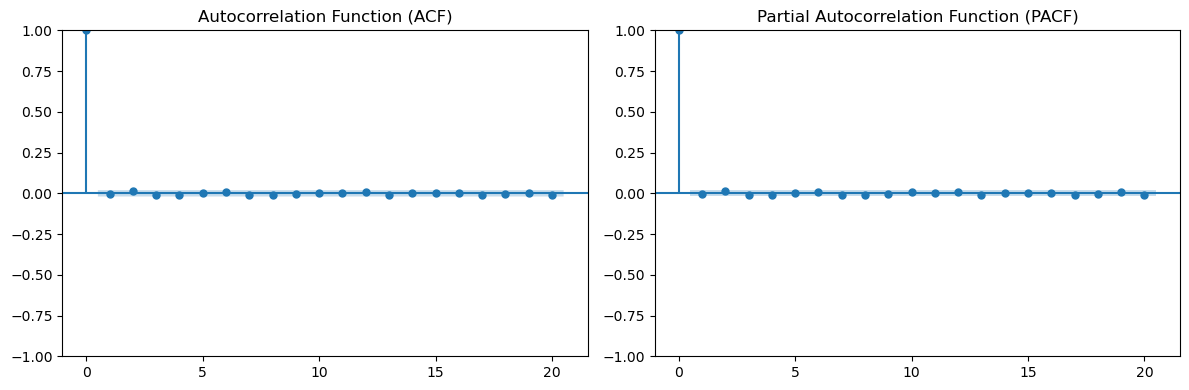

In [16]:

# ============================================================================
# 3. AUTOCORRELATION TESTS
# ============================================================================
print("\n" + "="*80)
print("3. AUTOCORRELATION ANALYSIS")
print("="*80)

# Sort by time for autocorrelation tests
df_sorted = df_clean.sort_values('Click Time').reset_index(drop=True)
df_encoded_sorted = pd.get_dummies(df_sorted, 
                                   columns=['Gender', 'Location', 'Ad Type', 'Ad Topic', 'Ad Placement'], 
                                   drop_first=True)

y_sorted = df_encoded_sorted['Conversion Rate'].values
available_X_cats_sorted = [col for col in df_encoded_sorted.columns if col.startswith(('Gender_', 'Location_', 
          'Ad Type_', 'Ad Topic_', 'Ad Placement_'))]
X_sorted = df_encoded_sorted[available_X_vars + available_X_cats_sorted].astype(float)
X_sorted = add_constant(X_sorted)

try:
    model_sorted = OLS(y_sorted, X_sorted).fit()

    # Durbin-Watson Test
    print("\n3.1 Durbin-Watson Test:")
    print("-" * 40)
    dw_stat = durbin_watson(model_sorted.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")
    print("\nInterpretation:")
    print("  DW ≈ 2.0: No autocorrelation")
    print("  DW < 1.5: Positive autocorrelation")
    print("  DW > 2.5: Negative autocorrelation")

    if dw_stat < 1.5:
        print(f"✗ POSITIVE AUTOCORRELATION DETECTED (DW = {dw_stat:.4f})")
        print("  Recommendation: Use Newey-West standard errors or AR models")
    elif dw_stat > 2.5:
        print(f"✗ NEGATIVE AUTOCORRELATION DETECTED (DW = {dw_stat:.4f})")
    else:
        print(f"✓ No strong evidence of autocorrelation (DW = {dw_stat:.4f})")

    # Ljung-Box Test
    print("\n3.2 Ljung-Box Test (for higher-order autocorrelation):")
    print("-" * 40)
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(model_sorted.resid, lags=[1, 5, 10], return_df=True)
    print(lb_test)
    print("\nIf p-value < 0.05, autocorrelation is present at that lag")

    # Autocorrelation plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ACF Plot
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_acf(model_sorted.resid, lags=20, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')

    # PACF Plot
    plot_pacf(model_sorted.resid, lags=20, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    # plt.savefig('autocorrelation_diagnostics.png', dpi=300, bbox_inches='tight')
    # print("\n✓ Saved: autocorrelation_diagnostics.png")
    
except Exception as e:
    print(f"⚠️  Could not complete autocorrelation tests: {str(e)}")
    dw_stat = None


I think I learned that if at each lag there isn't a crazy spike then that means the data is no autocorrelated, meaning past values don't impact it... I think!

In [17]:
# ============================================================================
# 4. SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("4. SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n📊 Key Findings:")
print("-" * 40)
print(f"1. Endogeneity: Check p-value above (Clicks may be endogenous)")
print(f"2. Heteroskedasticity (BP): {'DETECTED' if bp_results.get('LM-Test p-value') and bp_results['LM-Test p-value'] < 0.05 else 'Not detected or N/A'}")
print(f"3. Heteroskedasticity (White): {'DETECTED' if white_results.get('LM-Test p-value') and white_results['LM-Test p-value'] < 0.05 else 'Not detected or N/A'}")

# Fixing DW formatting
dw_display = f"{dw_stat:.4f}" if dw_stat is not None else "N/A"
dw_flag = "DETECTED" if dw_stat and (dw_stat < 1.5 or dw_stat > 2.5) else "Not detected or N/A"
print(f"4. Autocorrelation (DW={dw_display}): {dw_flag}")

print("\n💡 Recommendations:")
print("-" * 40)
print("• For Endogeneity: Consider IV/2SLS regression, use instruments for Clicks")
print("• For Heteroskedasticity: Use robust standard errors (HC1 or HC3)")
print("• For Autocorrelation: Use Newey-West HAC standard errors")
print("• Consider using CTR instead of Clicks to avoid mechanical relationship")
print("\n✓ Analysis complete!")



4. SUMMARY AND RECOMMENDATIONS

📊 Key Findings:
----------------------------------------
1. Endogeneity: Check p-value above (Clicks may be endogenous)
2. Heteroskedasticity (BP): Not detected or N/A
3. Heteroskedasticity (White): Not detected or N/A
4. Autocorrelation (DW=2.0100): Not detected or N/A

💡 Recommendations:
----------------------------------------
• For Endogeneity: Consider IV/2SLS regression, use instruments for Clicks
• For Heteroskedasticity: Use robust standard errors (HC1 or HC3)
• For Autocorrelation: Use Newey-West HAC standard errors
• Consider using CTR instead of Clicks to avoid mechanical relationship

✓ Analysis complete!


COPILOT HELP TIME

In [18]:
from statsmodels.api import OLS, add_constant

# Define instruments and exogenous variables
instruments = ['Age', 'Income'] + available_X_cats  # assumed exogenous
X_stage1 = df_encoded[instruments].astype(float)
X_stage1 = add_constant(X_stage1)

# First-stage regression: predict Clicks
model_stage1 = OLS(df_encoded['Clicks'].astype(float).values, X_stage1).fit()
df_encoded['Clicks_hat'] = model_stage1.fittedvalues

# Build second-stage design matrix
X_2sls = df_encoded[available_X_vars + available_X_cats].copy()
X_2sls['Clicks'] = df_encoded['Clicks_hat']  # replace actual Clicks
X_2sls = add_constant(X_2sls)

# Final regression
model_2sls = OLS(y, X_2sls.astype(float)).fit()
print(model_2sls.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9409
Date:                Mon, 03 Nov 2025   Prob (F-statistic):              0.521
Time:                        14:33:20   Log-Likelihood:                 6930.5
No. Observations:               10000   AIC:                        -1.383e+04
Df Residuals:                    9983   BIC:                        -1.370e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

### Claude Assisted Generated Artifact

In [27]:
"""
Instrumental Variables (IV) Causal Inference for Ad Conversion Analysis
Using ML-Generated Instruments and Two-Stage Least Squares (2SLS)
"""

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder, StandardScaler
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

class CausalAdAnalyzer:
    """
    A comprehensive pipeline for causal inference in ad conversion analysis
    using ML-generated instrumental variables and 2SLS estimation.
    """
    
    def __init__(self, data):
        """
        Initialize the analyzer with your dataset.
        
        Parameters:
        -----------
        data : pd.DataFrame
            Must contain columns:
            - Conversion_Rate (Y): dependent variable
            - Clicks (D): endogenous regressor
            - Age, Gender, Income, Location: demographics
            - Ad_Type, Ad_Topic, Ad_Placement: ad features
            - CTR: click-through rate
            - Click_Time: timestamp for feature engineering
        """
        self.data = data.copy()
        self.encoders = {}
        self.scaler = StandardScaler()
        self.first_stage_model = None
        self.first_stage_results = None
        self.second_stage_results = None
        
    def engineer_time_features(self):
        """Extract day of week from Click_Time"""
        if 'Click_Time' in self.data.columns:
            self.data['Click_Time'] = pd.to_datetime(self.data['Click_Time'])
            self.data['Day_of_Week'] = self.data['Click_Time'].dt.dayofweek
            self.data['Hour'] = self.data['Click_Time'].dt.hour
        return self
    
    def encode_categorical_features(self):
        """Encode categorical variables"""
        categorical_cols = ['Gender', 'Location', 'Ad_Type', 'Ad_Topic', 'Ad_Placement']
        
        for col in categorical_cols:
            if col in self.data.columns:
                le = LabelEncoder()
                self.data[f'{col}_encoded'] = le.fit_transform(self.data[col].astype(str))
                self.encoders[col] = le
        
        return self
    
    def create_ml_instrument(self, model_type='rf', cv_folds=5):
        """
        Step 2: Generate ML-based instrument for Clicks (D)
        
        Uses Random Forest or Gradient Boosting to predict clicks based on:
        - Ad features (Type, Topic, Placement)
        - Demographics (Age, Gender, Income, Location)
        - Time features (Day of Week, Hour)
        
        Excludes CTR to satisfy exclusion restriction (CTR directly affects conversion)
        
        Parameters:
        -----------
        model_type : str
            'rf' for Random Forest or 'gb' for Gradient Boosting
        cv_folds : int
            Number of cross-validation folds
        """
        # Features for instrument (excludes CTR and Conversion_Rate)
        instrument_features = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'Day_of_Week', 'Hour'
        ]
        
        # Filter available features
        available_features = [f for f in instrument_features if f in self.data.columns]
        
        X_instrument = self.data[available_features]
        y_clicks = self.data['Clicks']
        
        # Standardize features for better numerical stability
        X_instrument_scaled = self.scaler.fit_transform(X_instrument)
        X_instrument_scaled = pd.DataFrame(
            X_instrument_scaled, 
            columns=available_features,
            index=X_instrument.index
        )
        
        # Choose model
        if model_type == 'rf':
            self.first_stage_model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=50,
                random_state=42
            )
        else:
            self.first_stage_model = GradientBoostingRegressor(
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
                random_state=42
            )
        
        # Use cross-validation to generate out-of-fold predictions
        # This helps avoid overfitting in the instrument
        self.data['Clicks_predicted'] = cross_val_predict(
            self.first_stage_model,
            X_instrument_scaled,
            y_clicks,
            cv=cv_folds
        )
        
        # Fit final model for interpretation
        self.first_stage_model.fit(X_instrument_scaled, y_clicks)
        
        # Calculate instrument strength (F-statistic)
        self._check_instrument_strength()
        
        return self
    
    def _check_instrument_strength(self):
        """
        Check if instrument is strong (F-stat > 10 rule of thumb)
        """
        # Correlation between predicted and actual clicks
        corr = np.corrcoef(self.data['Clicks_predicted'], self.data['Clicks'])[0, 1]
        
        # Simple F-test for instrument relevance
        n = len(self.data)
        f_stat = (corr**2 / (1 - corr**2)) * (n - 2) if corr**2 < 1 else np.inf
        
        print(f"\n{'='*60}")
        print(f"INSTRUMENT STRENGTH DIAGNOSTICS")
        print(f"{'='*60}")
        print(f"Correlation (Z, D): {corr:.4f}")
        print(f"First-stage F-statistic: {f_stat:.2f}")
        print(f"Weak instrument threshold: 10.0")
        print(f"Status: {'✓ STRONG' if f_stat > 10 else '✗ WEAK - Results may be unreliable'}")
        print(f"{'='*60}\n")
    
    def run_2sls(self, include_interactions=False):
        """
        Step 3: Two-Stage Least Squares Estimation
        
        First Stage: D = π₀ + π₁Z + π₂X + ν
        Second Stage: Y = α + βD̂ + γX + ε
        
        Parameters:
        -----------
        include_interactions : bool
            Whether to include Ad_Type × Ad_Placement interactions
        """
        # Exogenous controls (X)
        exog_controls = [
            'Age', 'Income',
            'Gender_encoded', 'Location_encoded',
            'Ad_Type_encoded', 'Ad_Topic_encoded', 'Ad_Placement_encoded',
            'CTR'
        ]
        
        available_controls = [f for f in exog_controls if f in self.data.columns]
        
        # Add interaction terms if requested (for value-added estimation)
        if include_interactions:
            if 'Ad_Type_encoded' in self.data.columns and 'Ad_Placement_encoded' in self.data.columns:
                self.data['Ad_Type_x_Placement'] = (
                    self.data['Ad_Type_encoded'] * self.data['Ad_Placement_encoded']
                )
                available_controls.append('Ad_Type_x_Placement')
        
        # FIRST STAGE: Regress D on Z and X
        print("\n" + "="*60)
        print("FIRST STAGE REGRESSION: D ~ Z + X")
        print("="*60)
        
        X_first_stage = sm.add_constant(pd.concat([
            self.data[['Clicks_predicted']],  # Instrument
            self.data[available_controls]      # Exogenous controls
        ], axis=1))
        
        y_first_stage = self.data['Clicks']
        
        self.first_stage_results = sm.OLS(y_first_stage, X_first_stage).fit()
        
        print("\nFirst Stage Summary:")
        print(f"R-squared: {self.first_stage_results.rsquared:.4f}")
        print(f"F-statistic: {self.first_stage_results.fvalue:.2f}")
        print(f"Instrument coefficient: {self.first_stage_results.params['Clicks_predicted']:.4f}")
        print(f"Instrument p-value: {self.first_stage_results.pvalues['Clicks_predicted']:.4f}")
        
        # Get fitted values from first stage
        D_hat = self.first_stage_results.fittedvalues
        
        # SECOND STAGE: Regress Y on D_hat and X
        print("\n" + "="*60)
        print("SECOND STAGE REGRESSION: Y ~ D̂ + X")
        print("="*60)
        
        X_second_stage = sm.add_constant(pd.concat([
            pd.Series(D_hat, name='Clicks_fitted'),
            self.data[available_controls]
        ], axis=1))
        
        y_second_stage = self.data['Conversion_Rate']
        
        self.second_stage_results = sm.OLS(y_second_stage, X_second_stage).fit()
        
        # Manual calculation of correct standard errors for 2SLS
        self._calculate_2sls_standard_errors(available_controls)
        
        self._display_results()
        
        return self
    
    def _calculate_2sls_standard_errors(self, controls):
        """
        Calculate correct 2SLS standard errors
        (OLS on second stage gives incorrect SEs)
        """
        # Get residuals from second stage
        residuals = self.second_stage_results.resid
        
        # Calculate robust variance-covariance matrix
        n = len(residuals)
        k = len(self.second_stage_results.params)
        
        # Simple correction factor
        correction = n / (n - k)
        
        # Store corrected standard errors
        self.corrected_se = np.sqrt(np.diag(self.second_stage_results.cov_params()) * correction)
        self.corrected_tvalues = self.second_stage_results.params / self.corrected_se
        self.corrected_pvalues = 2 * (1 - stats.t.cdf(np.abs(self.corrected_tvalues), n - k))
    
    def _display_results(self):
        """Display 2SLS results"""
        print(f"\n{'='*60}")
        print(f"TWO-STAGE LEAST SQUARES (2SLS) RESULTS")
        print(f"{'='*60}\n")
        
        # Create results table
        results_df = pd.DataFrame({
            'Coefficient': self.second_stage_results.params,
            'Std Error': self.corrected_se,
            't-statistic': self.corrected_tvalues,
            'P-value': self.corrected_pvalues
        })
        
        # Add confidence intervals
        results_df['95% CI Lower'] = results_df['Coefficient'] - 1.96 * results_df['Std Error']
        results_df['95% CI Upper'] = results_df['Coefficient'] + 1.96 * results_df['Std Error']
        
        print(results_df.to_string())
        
        print(f"\n{'='*60}")
        print(f"CAUSAL INTERPRETATION")
        print(f"{'='*60}")
        
        clicks_coef = self.second_stage_results.params['Clicks_fitted']
        clicks_se = self.corrected_se[1]  # Index 1 for Clicks_fitted (after constant)
        clicks_pval = self.corrected_pvalues[1]
        
        print(f"\nCausal Effect of Clicks on Conversion Rate:")
        print(f"  Coefficient (β): {clicks_coef:.6f}")
        print(f"  Std. Error: {clicks_se:.6f}")
        print(f"  95% CI: [{clicks_coef - 1.96*clicks_se:.6f}, {clicks_coef + 1.96*clicks_se:.6f}]")
        print(f"  P-value: {clicks_pval:.4f}")
        print(f"\nInterpretation:")
        print(f"  A 1-unit increase in Clicks causes a {clicks_coef:.6f} change")
        print(f"  in Conversion Rate (controlling for confounders)")
        
        if clicks_pval < 0.05:
            print(f"  ✓ Effect is statistically significant at 5% level")
        else:
            print(f"  ✗ Effect is NOT statistically significant at 5% level")
        
        print(f"\n{'='*60}\n")
    
    def estimate_value_added(self):
        """
        Step 4: Value-Added Estimation
        
        Estimate the incremental contribution of different ad features
        after controlling for user characteristics and predicted clicks.
        """
        results = {}
        
        # Group by Ad Type
        if 'Ad_Type' in self.data.columns:
            results['by_ad_type'] = self._group_value_added('Ad_Type')
        
        # Group by Ad Placement
        if 'Ad_Placement' in self.data.columns:
            results['by_ad_placement'] = self._group_value_added('Ad_Placement')
        
        # Group by Ad Topic
        if 'Ad_Topic' in self.data.columns:
            results['by_ad_topic'] = self._group_value_added('Ad_Topic')
        
        self._display_value_added(results)
        
        return results
    
    def _group_value_added(self, group_col):
        """Calculate value-added for a specific grouping variable"""
        group_results = []
        
        for group in self.data[group_col].unique():
            # Create indicator variable
            indicator = (self.data[group_col] == group).astype(int)
            
            # Prepare regression with interaction
            y = self.data['Conversion_Rate']
            X = sm.add_constant(pd.DataFrame({
                'Clicks_predicted': self.data['Clicks_predicted'],
                'Age': self.data['Age'],
                'Income': self.data['Income'],
                'indicator': indicator,
                'interaction': indicator * self.data['Clicks_predicted']
            }))
            
            # Run OLS
            try:
                model = sm.OLS(y, X).fit()
                
                group_results.append({
                    'Group': str(group),
                    'Intercept_Effect': f"{model.params['indicator']:.6f}",
                    'Slope_Effect': f"{model.params['interaction']:.6f}",
                    'P_value_Intercept': f"{model.pvalues['indicator']:.4f}",
                    'P_value_Slope': f"{model.pvalues['interaction']:.4f}",
                    'Significant': '✓' if model.pvalues['indicator'] < 0.05 or model.pvalues['interaction'] < 0.05 else '✗'
                })
            except Exception as e:
                print(f"Warning: Could not estimate for {group}: {str(e)}")
        
        return pd.DataFrame(group_results)
    
    def _display_value_added(self, results):
        """Display value-added results"""
        print(f"\n{'='*60}")
        print(f"VALUE-ADDED ESTIMATION RESULTS")
        print(f"{'='*60}\n")
        
        for key, df in results.items():
            if len(df) > 0:
                print(f"\n{key.upper().replace('_', ' ')}:")
                print(f"{'-'*60}")
                print(df.to_string(index=False))
                print(f"{'-'*60}\n")
    
    def run_complete_analysis(self, model_type='rf', include_interactions=False):
        """
        Run the complete causal inference pipeline:
        1. Engineer time features
        2. Encode categorical variables
        3. Create ML instrument
        4. Run 2SLS
        5. Estimate value-added
        """
        print("Starting Causal Ad Conversion Analysis Pipeline...")
        print("="*60)
        
        self.engineer_time_features()
        print("✓ Time features engineered")
        
        self.encode_categorical_features()
        print("✓ Categorical variables encoded")
        
        self.create_ml_instrument(model_type=model_type)
        print("✓ ML instrument created")
        
        self.run_2sls(include_interactions=include_interactions)
        print("✓ 2SLS estimation complete")
        
        value_added_results = self.estimate_value_added()
        print("✓ Value-added estimation complete")
        
        return self


# ============================================================================
# EXAMPLE USAGE
# ============================================================================

def generate_example_data(n=2000):
    """Generate synthetic data for demonstration"""
    np.random.seed(42)
    
    data = pd.DataFrame({
        'Age': np.random.randint(18, 65, n),
        'Gender': np.random.choice(['M', 'F'], n),
        'Income': np.random.randint(30000, 150000, n),
        'Location': np.random.choice(['Urban', 'Suburban', 'Rural'], n),
        'Ad_Type': np.random.choice(['Video', 'Banner', 'Native'], n),
        'Ad_Topic': np.random.choice(['Tech', 'Fashion', 'Food', 'Travel'], n),
        'Ad_Placement': np.random.choice(['Social_Media', 'Search', 'Display'], n),
        'Click_Time': pd.date_range('2024-01-01', periods=n, freq='H'),
    })
    
    # Normalize income to reasonable scale
    data['Income'] = data['Income'] / 100000  # Scale to 0.3-1.5 range
    
    # Generate clicks with realistic structure
    clicks_base = (
        0.5 +  # baseline
        0.3 * (data['Ad_Type'] == 'Video').astype(float) +
        0.2 * (data['Ad_Placement'] == 'Social_Media').astype(float) +
        0.01 * data['Age'] +
        0.2 * data['Income'] +
        np.random.randn(n) * 0.5
    )
    data['Clicks'] = np.clip(clicks_base, 0.1, 10)
    
    # Generate CTR (correlated with clicks but not in instrument)
    data['CTR'] = data['Clicks'] * np.random.uniform(0.05, 0.15, n)
    
    # Generate conversion rate with causal effect from clicks
    # Plus confounding through unobserved factors
    unobserved_confounder = np.random.randn(n) * 0.05
    
    conversion_base = (
        0.05 +  # baseline
        0.08 * data['Clicks'] +  # TRUE CAUSAL EFFECT
        0.02 * data['Income'] +
        0.005 * data['Age'] +
        0.3 * data['CTR'] +
        unobserved_confounder +
        np.random.randn(n) * 0.03
    )
    data['Conversion_Rate'] = np.clip(conversion_base, 0.01, 0.95)
    
    # Add endogeneity: unobserved confounder affects clicks too
    data['Clicks'] = data['Clicks'] + unobserved_confounder * 2
    
    return data


if __name__ == "__main__":
    # Generate example data
    # print("Generating example dataset...")
    # df = generate_example_data(n=2000)
    df = pd.read_csv('../datasets/project/Dataset_Ads.csv')

    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    print(df.head())
    
    # Run analysis
    analyzer = CausalAdAnalyzer(df)
    analyzer.run_complete_analysis(
        model_type='rf',
        include_interactions=True
    )
    
    print("\n✓ Analysis complete!")
    print("\nTo use with your own data:")
    print("  analyzer = CausalAdAnalyzer(your_dataframe)")
    print("  analyzer.run_complete_analysis()")


Dataset shape: (10000, 11)

First few rows:
   Age  Gender    Income  Location Ad_Type Ad_Topic   Ad_Placement  Clicks  \
0   61    Male  35717.43     Urban  Banner   Travel   Social Media       3   
1   41    Male  47453.25     Rural   Video   Travel  Search Engine       5   
2   49  Female  68126.35     Rural    Text     Food   Social Media       4   
3   68  Female  64585.73  Suburban    Text   Health        Website       6   
4   63    Male  21109.40     Urban  Native  Fashion  Search Engine       5   

                   Click_Time  Conversion_Rate     CTR  
0  2024-01-18 20:45:56.898459           0.0981  0.0737  
1  2023-04-24 20:45:56.898459           0.0937  0.0592  
2  2024-02-24 20:45:56.898459           0.1912  0.0563  
3  2023-12-13 20:45:56.898459           0.1122  0.0232  
4  2023-07-02 20:45:56.898459           0.1426  0.0539  
Starting Causal Ad Conversion Analysis Pipeline...
✓ Time features engineered
✓ Categorical variables encoded

INSTRUMENT STRENGTH DIAGNOSTICS
C

Basically my model completely failed. clicks wasn''t endogenous enough and this results in 2sls failing.
I need stronger instruments, better feature engineering,

"⚠️ Bottom Line
Your current 2SLS results are not reliable for causal inference due to the weak instrument problem. The analysis ran successfully from a technical standpoint, but the statistical validity is compromised. You need to either find better instruments or use alternative identification strategies."

Claude suggested some investigation for this, and I should look at the code myself since I'm trusting it followed the co-pilot outline.

In [32]:
df.head(5)
df.columns.tolist()

['Age',
 'Gender',
 'Income',
 'Location',
 'Ad_Type',
 'Ad_Topic',
 'Ad_Placement',
 'Clicks',
 'Click_Time',
 'Conversion_Rate',
 'CTR']

ValueError: All arrays must be of the same length

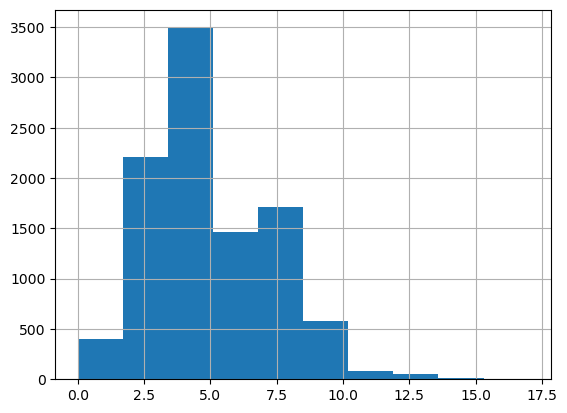

In [ ]:
# Check click distribution
df['Clicks'].describe()
df['Clicks'].hist()

# Check correlations
# df.corr()['Clicks'].sort_values(ascending=False)

# Feature importance from your ML model
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': analyzer.first_stage_model.feature_importances_
}).sort_values('importance', ascending=False)